# Galformer Model Training with TPU and CPU Support

This notebook trains a Transformer-based model (Galformer) for stock price prediction.
It is designed to run efficiently on both TPUs and CPUs, automatically detecting
the available hardware and adjusting accordingly.

In [31]:
# ! pip install --upgrade tensorflow==2.12

In [32]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, MultiHeadAttention, LayerNormalization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

## TPU Initialization

In [33]:
# Detect and initialize the TPU
try:
    # TPU detection
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU:', tpu.master())
except ValueError:
    tpu = None
    print('Not running on TPU')

if tpu:
    # Connect to the TPU cluster and initialize the system
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    # Default strategy if TPU is not available
    strategy = tf.distribute.get_strategy()

print('Number of accelerators: ', strategy.num_replicas_in_sync)

Not running on TPU
Number of accelerators:  1
Not running on TPU
Number of accelerators:  1


## Constants and Parameters

In [34]:
sequence_length = 60  # Should match the value used in data preparation
prediction_horizon = 5
per_replica_batch_size = 32
global_batch_size = per_replica_batch_size * strategy.num_replicas_in_sync
print('Global batch size:', global_batch_size)

Global batch size: 32
Global batch size: 32


## Mount Google Drive (if using Google Colab)

In [35]:
# # If you're using Google Colab and storing data on Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# # Change directory to where your TFRecord files are stored
# os.chdir('/content/drive/MyDrive/')
# print("Current Directory:", os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Define Feature Description

In [36]:
# Define feature description for parsing TFRecord files
feature_description = {
    'feature': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.string),
}

## Get the List of TFRecord Files

In [38]:
# List all TFRecord files
tfrecord_files = glob.glob('tfrecords_data/*.tfrecord')
print(f"Found {len(tfrecord_files)} TFRecord files.")

# Create a dataset from the list of TFRecord files
raw_dataset = tf.data.TFRecordDataset(tfrecord_files, compression_type='GZIP')

Found 10 TFRecord files.
Found 10 TFRecord files.


## Determine `num_features` from the Dataset

In [39]:
# Extract one example to determine num_features
for raw_record in raw_dataset.take(1):
    example = tf.io.parse_single_example(raw_record, feature_description)
    feature = tf.io.parse_tensor(example['feature'], out_type=tf.float32)
    label = tf.io.parse_tensor(example['label'], out_type=tf.float32)
    sequence_length = feature.shape[0]
    num_features = feature.shape[1]
    prediction_horizon = label.shape[0]
    print(f"Sequence Length: {sequence_length}, Num Features: {num_features}, Prediction Horizon: {prediction_horizon}")
    break

Sequence Length: 60, Num Features: 28, Prediction Horizon: 25
Sequence Length: 60, Num Features: 28, Prediction Horizon: 25


## Function to Parse TFRecord Examples

In [40]:
def parse_tfrecord_fn(example_proto):
    example = tf.io.parse_single_example(example_proto, feature_description)

    feature = tf.io.parse_tensor(example['feature'], out_type=tf.float32)
    label = tf.io.parse_tensor(example['label'], out_type=tf.float32)

    # Set shapes for feature and label
    feature.set_shape([sequence_length, num_features])
    label.set_shape([prediction_horizon])

    return feature, label

## Create `tf.data.Dataset` from TFRecord Files

In [41]:
# Parse the serialized data in the TFRecord files
parsed_dataset = raw_dataset.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)

# Determine the total dataset size
total_dataset_size = sum(1 for _ in parsed_dataset)
print(f"Total number of samples in dataset: {total_dataset_size}")

# Reset the parsed_dataset iterator after counting
parsed_dataset = raw_dataset.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)

Total number of samples in dataset: 251340
Total number of samples in dataset: 251340


## Split Dataset into Training and Testing Sets

In [42]:
# Shuffle and split the dataset
train_size = int(0.8 * total_dataset_size)
test_size = total_dataset_size - train_size

# Shuffle the entire dataset and split
parsed_dataset = parsed_dataset.shuffle(buffer_size=10000, reshuffle_each_iteration=False)

train_dataset = parsed_dataset.take(train_size)
test_dataset = parsed_dataset.skip(train_size)

# Batch and prefetch the datasets
train_dataset = train_dataset.batch(global_batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(global_batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

print(f"Training samples: {train_size}, Testing samples: {test_size}")

Training samples: 201072, Testing samples: 50268
Training samples: 201072, Testing samples: 50268


## Add Positional Encoding Function

In [43]:
def positional_encoding(sequence_length, d_model):
    position = tf.range(sequence_length, dtype=tf.float32)[:, tf.newaxis]
    i = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :]
    angle_rates = 1 / tf.pow(10000.0, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    angle_rads = position * angle_rates
    sin_terms = tf.sin(angle_rads[:, 0::2])
    cos_terms = tf.cos(angle_rads[:, 1::2])
    pos_encoding = tf.concat([sin_terms, cos_terms], axis=-1)
    return pos_encoding  # Shape: (sequence_length, d_model)

## Build and Compile the Galformer Model

In [44]:
# Initialize the Galformer model
input_shape = (sequence_length, num_features)  # (sequence_length, num_features)
output_length = prediction_horizon  # prediction_horizon

def build_galformer_model(input_shape, output_length):
    inputs = Input(shape=input_shape)  # input_shape = (sequence_length, num_features)

    # Create positional encodings
    pe = positional_encoding(input_shape[0], input_shape[1])
    pe = tf.expand_dims(pe, axis=0)  # Shape: (1, sequence_length, num_features)

    # Add positional encoding to inputs
    x = inputs + pe  # Broadcasting, pe shape is (1, sequence_length, num_features)

    # Transformer Encoder Layer
    attn_output = MultiHeadAttention(num_heads=4, key_dim=input_shape[1])(x, x)
    attn_output = Dropout(0.1)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(attn_output + x)

    # Feed Forward Network
    ffn_output = Dense(128, activation='relu')(out1)
    ffn_output = Dense(input_shape[1])(ffn_output)
    ffn_output = Dropout(0.1)(ffn_output)
    out2 = LayerNormalization(epsilon=1e-6)(ffn_output + out1)

    # Flatten and Output Layer
    x = Flatten()(out2)
    outputs = Dense(output_length, activation='linear')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Build and compile the model within the strategy scope
with strategy.scope():
    galformer_model = build_galformer_model(input_shape, output_length)

## Train the Galformer Model

In [45]:
history_galformer = galformer_model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    verbose=1
)

6283/6283 [==============================] - 301s 47ms/step - loss: 3229.1072 - mae: 34.6706 - val_loss: 1645.5146 - val_mae: 24.5736


## Plot Training & Validation Loss Values

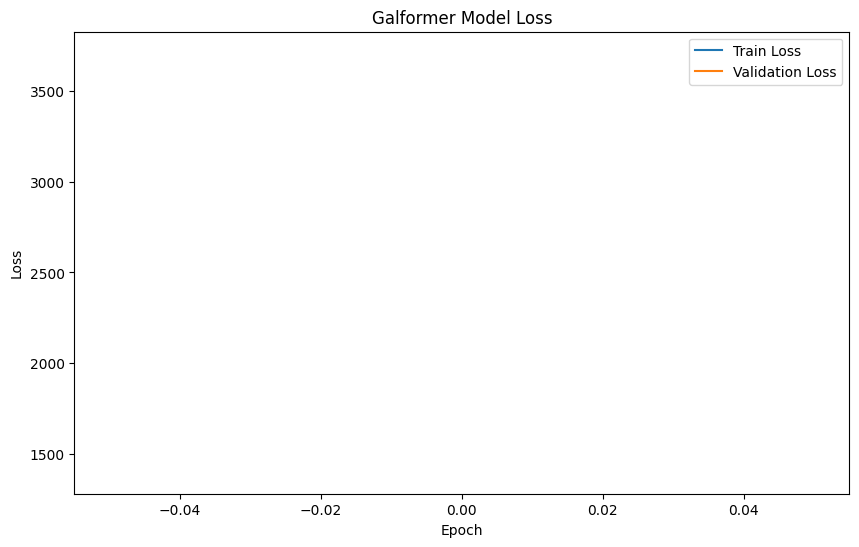

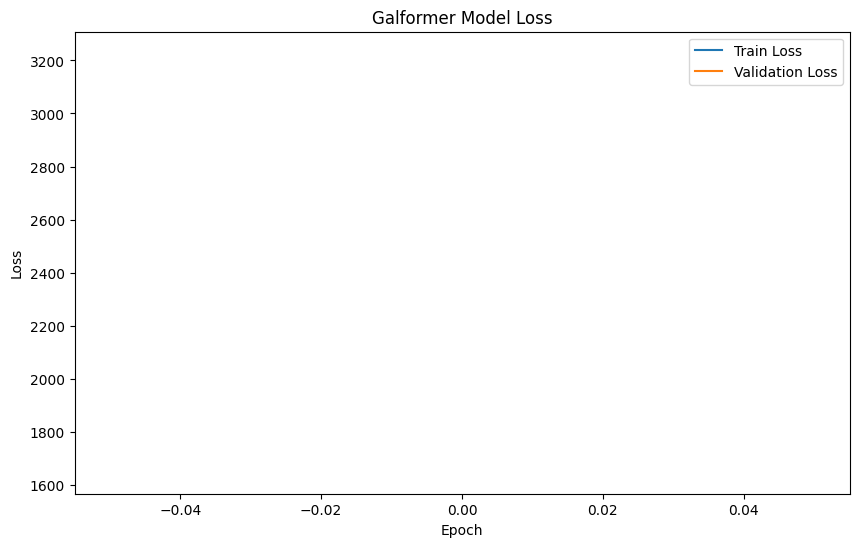

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(history_galformer.history['loss'], label='Train Loss')
plt.plot(history_galformer.history['val_loss'], label='Validation Loss')
plt.title('Galformer Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Evaluate the Galformer Model

In [47]:
test_loss_galformer, test_mae_galformer = galformer_model.evaluate(test_dataset, verbose=1)
print(f"Galformer Model - Test Loss: {test_loss_galformer:.4f}, Test MAE: {test_mae_galformer:.4f}")

1570/1570 [==============================] - 44s 18ms/step - loss: 1394.0417 - mae: 23.0925
Galformer Model - Test Loss: 1394.0417, Test MAE: 23.0925
1570/1570 [==============================] - 44s 18ms/step - loss: 1645.5146 - mae: 24.5736
Galformer Model - Test Loss: 1645.5146, Test MAE: 24.5736


## Predict on Test Data

1570/1570 [==============================] - 25s 16ms/step


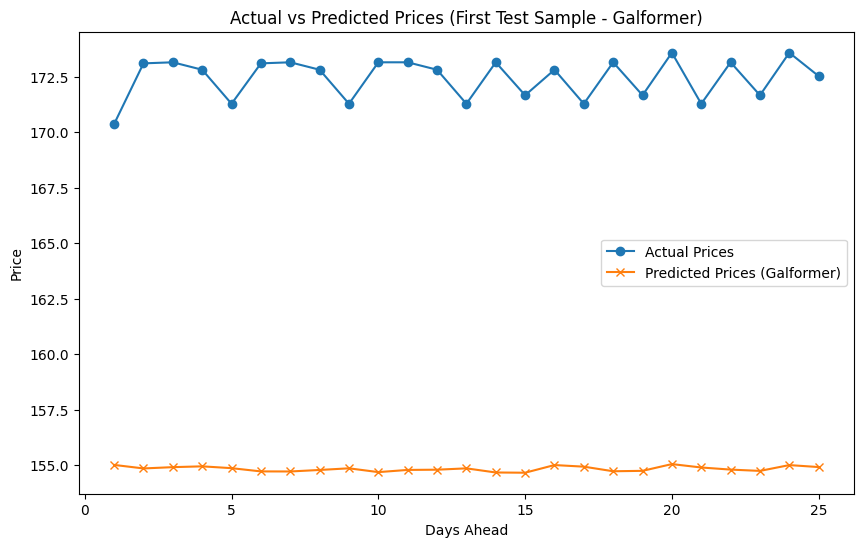

1570/1570 [==============================] - 25s 16ms/step


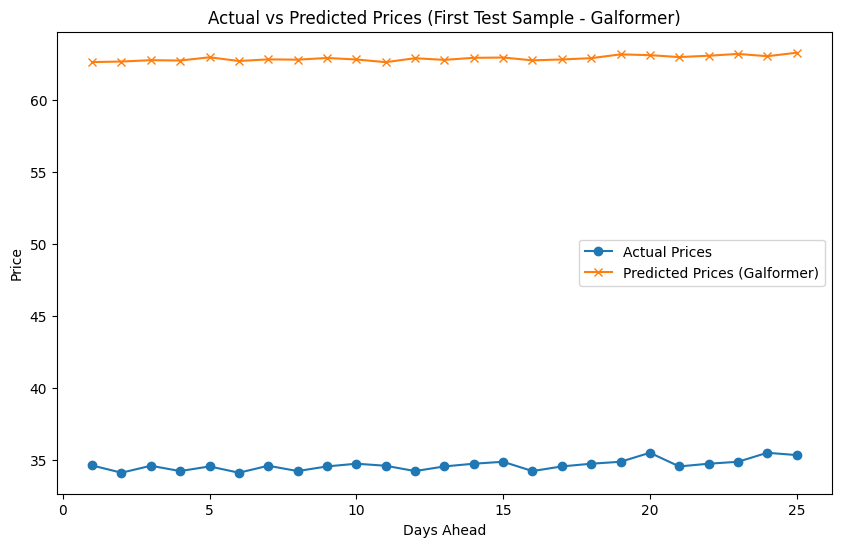

In [48]:
# Collect features and labels from test_dataset
X_test_list = []
y_test_list = []

for features, labels in test_dataset:
    X_test_list.append(features.numpy())
    y_test_list.append(labels.numpy())

# Concatenate lists to form arrays
X_test = np.concatenate(X_test_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)

# Predict on test data
def add_positional_encoding(inputs):
    pe = positional_encoding(inputs.shape[1], inputs.shape[2])
    pe = tf.expand_dims(pe, axis=0)  # Shape: (1, sequence_length, num_features)
    inputs_with_pe = inputs + pe.numpy()
    return inputs_with_pe

X_test_with_pe = add_positional_encoding(X_test)
y_pred_galformer = galformer_model.predict(X_test_with_pe)

# Visualize predictions for the first test sample
plt.figure(figsize=(10, 6))

# Plot Actual Prices for the first test sample
plt.plot(range(1, output_length + 1), y_test[0], label="Actual Prices", marker='o')

# Plot Predicted Prices for the first test sample (Galformer)
plt.plot(range(1, output_length + 1), y_pred_galformer[0], label="Predicted Prices (Galformer)", marker='x')

plt.title("Actual vs Predicted Prices (First Test Sample - Galformer)")
plt.xlabel("Days Ahead")
plt.ylabel("Price")
plt.legend()
plt.show()

## Save the Galformer Model

In [49]:
galformer_model.save('generalized_stock_galformer_model.keras')
print("Galformer Model has been saved to 'generalized_stock_galformer_model.keras'.")

Galformer Model has been saved to 'generalized_stock_galformer_model.keras'.
Galformer Model has been saved to 'generalized_stock_galformer_model.keras'.


## Inference with New Data

### Load Company Data for Inference

In [50]:
def load_company_data():
    all_dfs = {}
    parquet_files = glob.glob('df_*.parquet')
    for file in parquet_files:
        key = file.split('.')[0]  # e.g., 'df_AAPL'
        df = pd.read_parquet(file)
        all_dfs[key] = df
    return all_dfs

all_dfs = load_company_data()

### Prepare Data for Inference

In [51]:
def prepare_inference_data(company_df, sequence_length=60):
    """
    Prepare input data for inference for a single company.
    Args:
        company_df (DataFrame): The DataFrame for a specific company.
        sequence_length (int): The number of past days to consider as input.

    Returns:
        numpy array: The input data ready for prediction.
    """
    # Ensure data is sorted by date
    company_df = company_df.sort_index()

    # Select relevant input features (exclude targets)
    input_features = company_df.filter(regex="^(?!.*target).*").values

    # Take the last `sequence_length` days as input for prediction
    if len(input_features) >= sequence_length:
        input_sequence = input_features[-sequence_length:]
        # Ensure the input sequence has the correct shape
        input_sequence = np.expand_dims(input_sequence, axis=0)  # Add batch dimension
        return input_sequence.astype(np.float32)  # Ensure data type consistency
    else:
        raise ValueError("Insufficient data for inference (less than sequence length).")

### Make Predictions for Each Company

In [52]:
def get_galformer_predictions_for_company(company_df, galformer_model, sequence_length=60):
    """
    Get Galformer predictions for a single company using the trained model.
    Args:
        company_df (DataFrame): DataFrame of the company.
        galformer_model: Trained Galformer model.
        sequence_length (int): Number of past days to consider as input.

    Returns:
        numpy array: Predicted prices.
    """
    try:
        # Prepare data for inference
        input_data = prepare_inference_data(company_df, sequence_length=sequence_length)

        # Add positional encoding to inference data
        pe = positional_encoding(input_data.shape[1], input_data.shape[2])
        pe = tf.expand_dims(pe, axis=0)  # Shape: (1, sequence_length, num_features)
        input_data_with_pe = input_data + pe.numpy()

        # Make predictions with Galformer
        pred_galformer = galformer_model.predict(input_data_with_pe)
        return pred_galformer.flatten()
    except ValueError as e:
        print(f"Skipping due to error: {e}")
        return None

### Load the Trained Model

In [53]:
# Load the trained Galformer model
galformer_model = tf.keras.models.load_model('generalized_stock_galformer_model.keras')

### Make Predictions for All Companies

In [54]:
def get_galformer_predictions_for_all_companies(all_dfs, galformer_model, sequence_length=60):
    """
    Get Galformer predictions for all companies.
    """
    all_predictions = {}
    for company_key, company_df in all_dfs.items():
        print(f"Processing {company_key}...")
        predictions = get_galformer_predictions_for_company(company_df, galformer_model, sequence_length=sequence_length)
        if predictions is not None:
            all_predictions[company_key] = predictions
        else:
            print(f"Predictions not available for {company_key}.")
    return all_predictions

In [55]:
# Get predictions for all companies
all_company_predictions = get_galformer_predictions_for_all_companies(all_dfs, galformer_model, sequence_length=60)

### Save Predictions

In [56]:
def predictions_to_dataframe(predictions_dict):
    """
    Convert predictions dictionary to a DataFrame.
    """
    records = []
    for company_key, pred_values in predictions_dict.items():
        for day_ahead, value in enumerate(pred_values, start=1):
            records.append({
                'Company': company_key.replace('df_', ''),
                'Day_Ahead': day_ahead,
                'Predicted_Price': value
            })
    return pd.DataFrame(records)

predictions_df = predictions_to_dataframe(all_company_predictions)
predictions_df.head()

""


""


In [57]:
# Save the predictions DataFrame to a CSV file
predictions_df.to_csv('galformer_stock_price_predictions.csv', index=False)
print("Galformer Predictions have been saved to 'galformer_stock_price_predictions.csv'.")

Galformer Predictions have been saved to 'galformer_stock_price_predictions.csv'.
Galformer Predictions have been saved to 'galformer_stock_price_predictions.csv'.
